In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil

from tensorflow.contrib.learn import DNNClassifier
import scikitplot as skplt

#plt.style.use('fivethirtyeight')

# Parameters

In [2]:
root_path = "../"
path_model = root_path + 'models/test'
features_path = root_path + 'data/features/dataset_tfid_hash28_n1000.p'

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

### Output

In [3]:
X_train,y_train,X_test,y_test = pickle.load( open( features_path, "rb" ) )


In [4]:
# labels = list(set(y))
# nClasses = len(labels)

# scale_factor = 10e3
# sizes = {label: y_train[y_train == label].shape[0] for label in labels}
# weights = np.asarray([scale_factor/sizes[label] for label in y])


# weights = weights[:,np.newaxis]
# weights_train = weights[train_indices]
# weights_test = weights[test_indices]


In [5]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)

# Model

### DNN graph generation

In [6]:
epochs = 14000

# Define the test inputs
def get_train_inputs():    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train.todense(),'class_weights': weights_train},
                                                  y_train[:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=50,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs():
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test.todense(),'class_weights': weights_test},
                                                  y_test[:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [7]:



feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=X_train.shape[1])]

optimizer = tf.train.ProximalAdagradOptimizer(
                              learning_rate=0.1,
                              l1_regularization_strength= 0.0#0.0001
                              )

classifier = DNNClassifier(                                
                           n_classes=len(labels), label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000], #2000, 1000, 100
                           dropout=0.5,
                           #optimizer = optimizer,
                           weight_column_name='class_weights',
                           model_dir = path_model,
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                           save_checkpoints_secs = None)                           
                          )

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3582d96908>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../models/test'}


# Training



In [8]:
tf.set_random_seed(42)

    
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    #input_fn= get_train_inputs(),
    input_fn= get_test_inputs(),
    
    every_n_steps=500,
    #early_stopping_metric="accuracy",#loss
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=3000)

start = time.time()
print("start")

#classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)
classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

end = time.time()
print("Training time :" + str(end - start) )


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
start
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../models/test/model.ckpt.
INFO:tensorflow:loss = 1.8902457, step = 0
INFO:tensorflow:global_step/sec: 256.896
INFO:tensorflow:loss = 1.5588794, step = 100 (0.390 sec)
INFO:tensorflow:global_step/sec: 305.643
INFO:tensorflow:loss = 1.1502968, step = 200 (0.329 sec)
INFO:tensorflow:global_step/sec: 306.118
INFO:tensorflow:loss = 1.7393909, step = 300 (0.325 sec)
INFO:tensorflow:global_step/sec: 300.272
INFO:tensorflow:loss = 1.3758246, step = 400 (0.333 sec)
INFO:tensorflow:Saving checkpoints for 501 into ../models/test/m

INFO:tensorflow:loss = 0.9656369, step = 4700 (0.315 sec)
INFO:tensorflow:global_step/sec: 309.795
INFO:tensorflow:loss = 0.36765137, step = 4800 (0.321 sec)
INFO:tensorflow:global_step/sec: 303.226
INFO:tensorflow:loss = 0.4457152, step = 4900 (0.332 sec)
INFO:tensorflow:Saving checkpoints for 5001 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 254.403
INFO:tensorflow:Starting evaluation at 2018-10-03-12:39:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-5001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-03-12:39:29
INFO:tensorflow:Saving dict for global step 5001: accuracy = 0.7895827, global_step = 5001, loss = 0.6228816
INFO:tensorflow:Validation (step 5000): loss = 0.6228816, accuracy = 0.7895827, global_step = 5001
INFO:tensorflow:loss = 0.862072, step = 5000 (1.797 sec)
INFO:tensorflow:global_step/sec: 57.4679
INFO:tens

INFO:tensorflow:global_step/sec: 304.338
INFO:tensorflow:loss = 0.62973595, step = 9800 (0.328 sec)
INFO:tensorflow:global_step/sec: 314.049
INFO:tensorflow:loss = 0.38397372, step = 9900 (0.319 sec)
INFO:tensorflow:Saving checkpoints for 10001 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 255.179
INFO:tensorflow:loss = 0.69244784, step = 10000 (0.393 sec)
INFO:tensorflow:global_step/sec: 302.147
INFO:tensorflow:loss = 0.26664641, step = 10100 (0.331 sec)
INFO:tensorflow:global_step/sec: 310.403
INFO:tensorflow:loss = 0.18690924, step = 10200 (0.322 sec)
INFO:tensorflow:global_step/sec: 296.426
INFO:tensorflow:loss = 0.45710927, step = 10300 (0.338 sec)
INFO:tensorflow:global_step/sec: 311.838
INFO:tensorflow:loss = 0.6268322, step = 10400 (0.320 sec)
INFO:tensorflow:Saving checkpoints for 10501 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 259.122
INFO:tensorflow:loss = 0.37250465, step = 10500 (0.386 sec)
INFO:tensorflow:global_step/sec: 306.089


# Evaluation performance


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


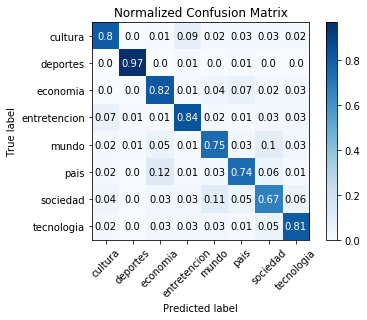

## Accuracy in test: 83.16933255171259 

In [9]:
def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test.todense())}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))